In [1]:
from datasets import Dataset, DatasetDict, load_metric, load_dataset
import numpy as np
import os
from PIL import Image

import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import (  # Import image transformation functions
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
import itertools  # Import 'itertools' for iterators and looping

### Reading custom data using load_dataset method from dataset library

In [3]:
data_path = 'data/custom_train_images'
dataset = load_dataset("imagefolder", data_dir=data_path)

print(dataset)
print(dataset['train'][0])
print(dataset['train'].features)

Resolving data files:   0%|          | 0/685 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 685
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1548x2253 at 0x250036E5BB0>, 'label': 0}
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Anger', 'Confused', 'Disgust', 'Happy', 'Neutral', 'Sad', 'Surprise'], id=None)}


### Load image processor from stage 1 model

In [4]:
checkpoint = "vit-affectnet-emotion-recognition"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Set label-to-ID and ID-to-label mappings

In [5]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

label2id

{'Anger': 0,
 'Confused': 1,
 'Disgust': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

### Apply data transformations

In [8]:
# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = image_processor.image_mean, image_processor.image_std

# Get the size (height) of the ViT model's input images
size = image_processor.size["height"]

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
train_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                          # Normalize images using mean and std
    ]
)
# Define a set of transformations for validation data
val_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

print("Size: ", size)

Size:  224


### Split up training into training + validation

In [2]:
splits = dataset["train"].train_test_split(test_size=0.15)
train_data = splits['train']
val_data = splits['test']

### Define specific transformations to be applied for training and validation datasets

In [10]:
# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

train_data.set_transform(train_transforms)
val_data.set_transform(val_transforms)
train_data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1202x1684>,
 'label': 4,
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  

### Loading trained model from stage 1

In [11]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

### Set up the training arguments

In [30]:
model_name = "vit-affectnet-custom-emotion-recognition"

args = TrainingArguments(
    f"{model_name}",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",  # Align with evaluation_strategy
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    auto_find_batch_size=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=32,
    weight_decay=0.1,
    num_train_epochs=50,
    warmup_steps=1000,
    logging_steps=50,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="none"
)

c:\Users\NIVEDITHA\Anaconda3\envs\cs731\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Define metrics to compute while training

In [31]:
from datasets import load_metric

metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

### Set up the Trainer class to handle training, evaluation, and inference

In [32]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

### Training the model

In [33]:
train_results = trainer.train()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'loss': 1.4393, 'grad_norm': 7.59151029586792, 'learning_rate': 1.5e-06, 'epoch': 10.81}
{'loss': 0.7209, 'grad_norm': 3.433994770050049, 'learning_rate': 3e-06, 'epoch': 21.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.5301446914672852, 'eval_accuracy': 0.8155339805825242, 'eval_runtime': 5.8831, 'eval_samples_per_second': 17.508, 'eval_steps_per_second': 0.68, 'epoch': 21.62}
{'loss': 0.254, 'grad_norm': 2.5925729274749756, 'learning_rate': 4.5e-06, 'epoch': 32.43}
{'loss': 0.0966, 'grad_norm': 2.14214825630188, 'learning_rate': 6e-06, 'epoch': 43.24}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.16715261340141296, 'eval_accuracy': 0.9320388349514563, 'eval_runtime': 6.6148, 'eval_samples_per_second': 15.571, 'eval_steps_per_second': 0.605, 'epoch': 43.24}
{'train_runtime': 2265.2684, 'train_samples_per_second': 12.846, 'train_steps_per_second': 0.088, 'train_loss': 0.6277107834815979, 'epoch': 43.24}


### Evaluating the model

In [34]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/4 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =    43.2432
  eval_accuracy           =      0.932
  eval_loss               =     0.1672
  eval_runtime            = 0:00:05.92
  eval_samples_per_second =      17.38
  eval_steps_per_second   =      0.675


In [36]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(val_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

  0%|          | 0/4 [00:00<?, ?it/s]

{'test_loss': 0.16715261340141296, 'test_accuracy': 0.9320388349514563, 'test_runtime': 5.6897, 'test_samples_per_second': 18.103, 'test_steps_per_second': 0.703}


### Calculate metrics and create confusion matrix

Accuracy: 0.9320
F1 Score: 0.9351


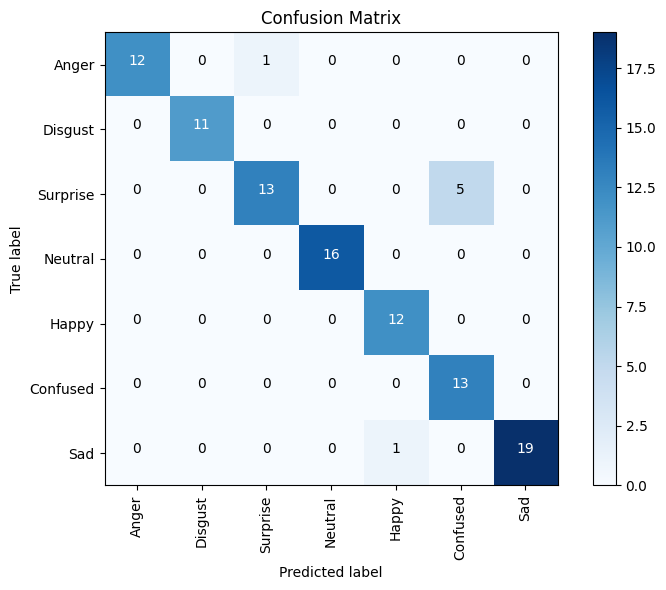


Classification report:

              precision    recall  f1-score   support

       Anger     1.0000    0.9231    0.9600        13
     Disgust     1.0000    1.0000    1.0000        11
    Surprise     0.9286    0.7222    0.8125        18
     Neutral     1.0000    1.0000    1.0000        16
       Happy     0.9231    1.0000    0.9600        12
    Confused     0.7222    1.0000    0.8387        13
         Sad     1.0000    0.9500    0.9744        20

    accuracy                         0.9320       103
   macro avg     0.9391    0.9422    0.9351       103
weighted avg     0.9435    0.9320    0.9322       103



In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score  

labels_list = list(set(labels))

# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))